<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/examples/multi_modal/ChromaMultiModalDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chroma Multi-Modal Demo with LlamaIndex

>[Chroma](https://docs.trychroma.com/getting-started) is a AI-native open-source vector database focused on developer productivity and happiness. Chroma is licensed under Apache 2.0.

<a href="https://discord.gg/MMeYNTmh3x" target="_blank">
      <img src="https://img.shields.io/discord/1073293645303795742" alt="Discord">
  </a>&nbsp;&nbsp;
  <a href="https://github.com/chroma-core/chroma/blob/master/LICENSE" target="_blank">
      <img src="https://img.shields.io/static/v1?label=license&message=Apache 2.0&color=white" alt="License">
  </a>&nbsp;&nbsp;
  <img src="https://github.com/chroma-core/chroma/actions/workflows/chroma-integration-test.yml/badge.svg?branch=main" alt="Integration Tests">

- [Website](https://www.trychroma.com/)
- [Documentation](https://docs.trychroma.com/)
- [Twitter](https://twitter.com/trychroma)
- [Discord](https://discord.gg/MMeYNTmh3x)

Chroma is fully-typed, fully-tested and fully-documented.

Install Chroma with:

```sh
pip install chromadb
```

Chroma runs in various modes. See below for examples of each integrated with LangChain.
- `in-memory` - in a python script or jupyter notebook
- `in-memory with persistance` - in a script or notebook and save/load to disk
- `in a docker container` - as a server running your local machine or in the cloud

Like any other database, you can: 
- `.add` 
- `.get` 
- `.update`
- `.upsert`
- `.delete`
- `.peek`
- and `.query` runs the similarity search.

View full docs at [docs](https://docs.trychroma.com/reference/Collection). 

## Basic Example

In this basic example, we take the a Paul Graham essay, split it into chunks, embed it using an open-source embedding model, load it into Chroma, and then query it.

If you're opening this Notebook on colab, you will probably need to install LlamaIndex 🦙.

In [1]:
!pip install llama-index --upgrade

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.2/990.2 kB 45.8 MB/s eta 0:00:00
  Attempting uninstall: llama-index
    Found existing installation: llama-index 0.9.16
    Uninstalling llama-index-0.9.16:
      Successfully uninstalled llama-index-0.9.16


#### Creating a Chroma Index

In [2]:
!pip install llama-index chromadb --quiet --upgrade
#!pip install chromadb==0.4.17
!pip install sentence-transformers --upgrade
#!pip install pydantic==1.10.11
!pip install open-clip-torch --upgrade

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 72.8 MB/s eta 0:00:00
  Attempting uninstall: open-clip-torch
    Found existing installation: open-clip-torch 2.20.0
    Uninstalling open-clip-torch-2.20.0:
      Successfully uninstalled open-clip-torch-2.20.0


In [1]:
# import
from llama_index import VectorStoreIndex, SimpleDirectoryReader, ServiceContext
from llama_index.vector_stores import ChromaVectorStore
from llama_index.storage.storage_context import StorageContext
from llama_index.embeddings import HuggingFaceEmbedding
from IPython.display import Markdown, display
import chromadb

In [2]:
# set up OpenAI
import os
import openai

#OPENAI_API_KEY = ""
openai.api_key = OPENAI_API_KEY = os.getenv("openai_api_token")
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

## Download Images and Texts from Wikipedia

In [3]:
import requests


def get_wikipedia_images(title):
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "imageinfo",
            "iiprop": "url|dimensions|mime",
            "generator": "images",
            "gimlimit": "50",
        },
    ).json()
    image_urls = []
    for page in response["query"]["pages"].values():
        if page["imageinfo"][0]["url"].endswith(".jpg") or page["imageinfo"][
            0
        ]["url"].endswith(".png"):
            image_urls.append(page["imageinfo"][0]["url"])
    return image_urls

In [6]:
from pathlib import Path
import urllib.request

image_uuid = 0
MAX_IMAGES_PER_WIKI = 20

wiki_titles = {
    "Tesla Model X",
    "Pablo Picasso",
    "Rivian",
    "The Lord of the Rings",
    "The Matrix",
    "The Simpsons",
}

data_path = Path("mixed_wiki")
if not data_path.exists():
    Path.mkdir(data_path)

for title in wiki_titles:
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "extracts",
            "explaintext": True,
        },
    ).json()
    page = next(iter(response["query"]["pages"].values()))
    wiki_text = page["extract"]

    with open(data_path / f"{title}.txt", "w") as fp:
        fp.write(wiki_text)

    images_per_wiki = 0
    try:
        # page_py = wikipedia.page(title)
        list_img_urls = get_wikipedia_images(title)
        # print(list_img_urls)

        for url in list_img_urls:
            if url.endswith(".jpg") or url.endswith(".png"):
                image_uuid += 1
                # image_file_name = title + "_" + url.split("/")[-1]

                urllib.request.urlretrieve(
                    url, data_path / f"{image_uuid}.jpg"
                )
                images_per_wiki += 1
                # Limit the number of images downloaded per wiki page to 15
                if images_per_wiki > MAX_IMAGES_PER_WIKI:
                    break
    except:
        print(str(Exception("No images found for Wikipedia page: ")) + title)
        continue

No images found for Wikipedia page: The Simpsons
No images found for Wikipedia page: The Lord of the Rings
No images found for Wikipedia page: Pablo Picasso
No images found for Wikipedia page: Tesla Model X


## Set the embedding model

In [7]:
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction

# set defalut text and image embedding functions
embedding_function = OpenCLIPEmbeddingFunction()

## Build Chroma Multi-Modal Index with LlamaIndex

In [8]:
from llama_index.indices.multi_modal.base import MultiModalVectorStoreIndex
from llama_index.vector_stores import QdrantVectorStore
from llama_index import SimpleDirectoryReader, StorageContext
from chromadb.utils.data_loaders import ImageLoader

image_loader = ImageLoader()

# create client and a new collection
chroma_client = chromadb.EphemeralClient()
chroma_collection = chroma_client.create_collection(
    "multimodal_collection",
    embedding_function=embedding_function,
    data_loader=image_loader,
)


# load documents
documents = SimpleDirectoryReader("./mixed_wiki/").load_data()

# set up ChromaVectorStore and load in data
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
storage_context = StorageContext.from_defaults(vector_store=vector_store)
index = VectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
)

## Retrieve results from Multi-Modal Index

In [9]:
retriever = index.as_retriever(similarity_top_k=50)
retrieval_results = retriever.retrieve("Picasso famous paintings")

**Node ID:** 98a90f3d-079a-4270-b4eb-1276cbf2049b<br>**Similarity:** 0.7744944295356757<br>**Text:** == Artistic legacy ==
Picasso's influence was and remains immense and widely acknowledged by his ...<br>

**Node ID:** bd13f5d7-c411-4753-a3d6-3bef3a1419d2<br>**Similarity:** 0.7713069795139397<br>**Text:** Pablo Ruiz Picasso (25 October 1881 – 8 April 1973) was a Spanish painter, sculptor, printmaker, ...<br>

**Node ID:** f5e060ea-bf54-454a-bb8e-6169a50dff62<br>**Similarity:** 0.7696770593850818<br>**Text:** === Later works to final years: 1949–1973 ===
Picasso was one of 250 sculptors who exhibited in t...<br>

**Node ID:** cb800b1d-bdef-4f76-8d0a-ecca2c7e9b70<br>**Similarity:** 0.7674893504011682<br>**Text:** === Neoclassicism and surrealism: 1919–1929 ===
In February 1917, Picasso made his first trip to ...<br>

**Node ID:** fba05074-2a97-463f-b9db-b31b811e3808<br>**Similarity:** 0.7656482984602305<br>**Text:** === The Basel vote ===
In the 1940s, a Swiss insurance company based in Basel had bought two pain...<br>

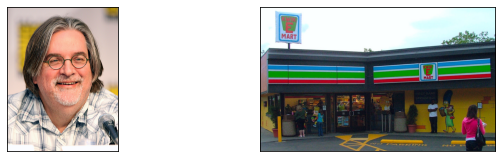

In [10]:
# print(retrieval_results)
from llama_index.schema import ImageNode
from llama_index.response.notebook_utils import (
    display_source_node,
    display_image_uris,
)


image_results = []
MAX_RES = 5
cnt = 0
for r in retrieval_results:
    if isinstance(r.node, ImageNode):
        image_results.append(r.node.metadata["file_path"])
    else:
        if cnt < MAX_RES:
            display_source_node(r)
        cnt += 1

display_image_uris(image_results, [3, 3], top_k=2)